In [20]:
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Add, Activation, BatchNormalization, AveragePooling2D
from keras.models import Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import ipywidgets as widgets
import os
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model


In [21]:

# Define the image size and labels
image_size = 150
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [22]:

# Define the image size and labels
image_size = 150
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Load and preprocess the data (assuming your data loading part remains the same)
X_train = []
Y_train = []
for i in labels:
    folderPath = os.path.join("C:/Users/Sourin Dey/Desktop/Brain-Tumor-Detection/Dataset/Training/", i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        Y_train.append(i)

for i in labels:
    folderPath = os.path.join('C:/Users/Sourin Dey/Desktop/Brain-Tumor-Detection/Dataset/Testing/', i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        Y_train.append(i)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_train, Y_train = shuffle(X_train, Y_train, random_state=101)
X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=101)

y_train_new = [labels.index(i) for i in y_train]
y_train = tf.keras.utils.to_categorical(y_train_new)

y_test_new = [labels.index(i) for i in y_test]
y_test = tf.keras.utils.to_categorical(y_test_new)


In [23]:

# Define a basic residual block
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    # First convolutional layer
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolutional layer
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Adjust shortcut if the input and output dimensions don't match
    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add the shortcut to the main path
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [24]:
# Build the Custom CNN model
input_tensor = Input(shape=(image_size, image_size, 3))

# Initial convolutional layer
x = Conv2D(64, 7, strides=2, padding='same')(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(3, strides=2, padding='same')(x)

# Residual blocks
x = residual_block(x, 64)
x = residual_block(x, 64)

x = residual_block(x, 128, stride=2)
x = residual_block(x, 128)

x = residual_block(x, 256, stride=2)
x = residual_block(x, 256)

x = AveragePooling2D(pool_size=(7, 7))(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=x)

In [25]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [26]:
# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 75, 75,    │      9,472 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 75, 75,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 38, 38,    │          0 │ activation_20[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 38, 38,    │     36,928 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 38, 38,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 38, 38,    │     36,928 │ activation_21[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 38, 38,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 38, 38,    │          0 │ activation_22[0]… │
│                     │ 64)               │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 38, 38,    │          0 │ add_6[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 38, 38,    │     36,928 │ activation_23[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 38, 38,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 38, 38,    │     36,928 │ activation_24[0]

 Total params: 2,923,140 (11.15 MB)

 Trainable params: 2,918,660 (11.13 MB)

 Non-trainable params: 4,480 (17.50 KB)

In [27]:

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_split=0.1)

Epoch 1/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.5896 - loss: 0.9923 - val_accuracy: 0.3022 - val_loss: 9.0139
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.7694 - loss: 0.5770 - val_accuracy: 0.3165 - val_loss: 3.8314
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.8259 - loss: 0.4713 - val_accuracy: 0.8291 - val_loss: 0.4681
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.8584 - loss: 0.3739 - val_accuracy: 0.5554 - val_loss: 2.0087
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.8908 - loss: 0.3096 - val_accuracy: 0.7168 - val_loss: 0.7954
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.9138 - loss: 0.2367 - val_accuracy: 0.7627 - val_loss: 0.6208
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.9170 - loss: 0.2210 - val_accuracy: 0.7896 - val_loss: 0.6549
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.9359 - loss: 0.1687 - val_accu

In [28]:
model.save("bear.h5")

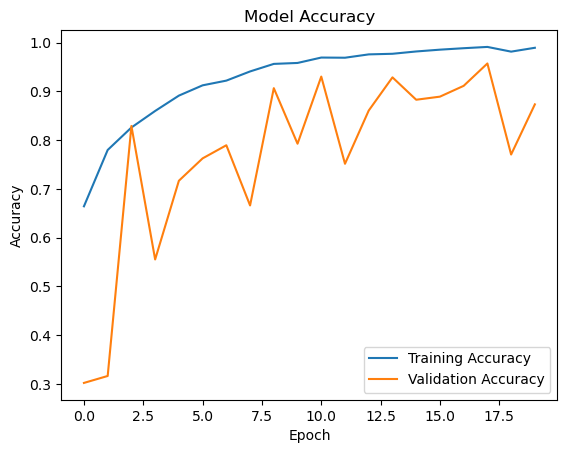

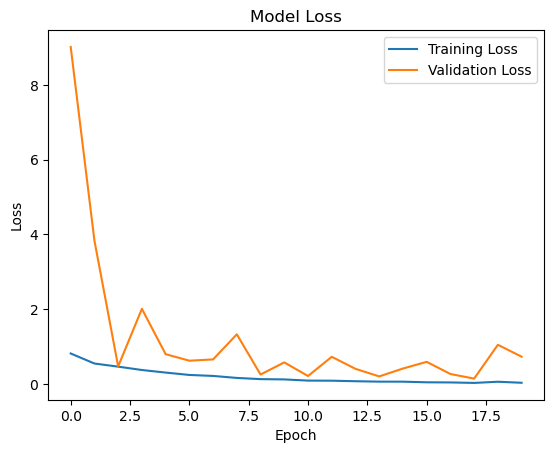

In [29]:
# Evaluate the model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [30]:

pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
y_test_original = np.argmax(y_test, axis=1)

print(classification_report(y_test_original, pred, target_names=labels))

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 333ms/step
              precision    recall  f1-score   support

      glioma       0.89      0.86      0.87       170
  meningioma       1.00      0.50      0.67       175
     notumor       0.95      0.98      0.96       202
   pituitary       0.64      0.99      0.78       156

    accuracy                           0.83       703
   macro avg       0.87      0.83      0.82       703
weighted avg       0.88      0.83      0.83       703



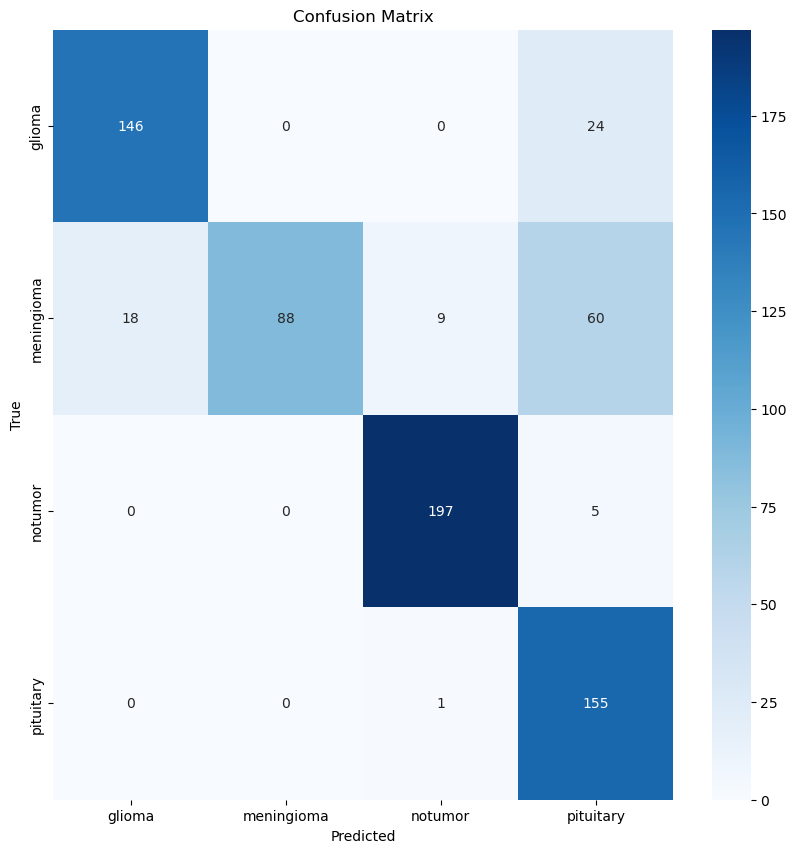

In [33]:
mat = confusion_matrix(y_test_original, pred)
plt.figure(figsize=(10, 10))
sns.heatmap(mat,fmt='d', annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("C:/Users/Sourin Dey/Desktop/Brain-Tumor-Detection/Dataset/confusion_matrix/confusion_matrix_resnet.png")
plt.show()

In [36]:
def random_crop(img, crop_size=100):
    height, width = img.shape[:2]
    start_x = np.random.randint(0, width - crop_size)
    start_y = np.random.randint(0, height - crop_size)
    return img[start_y:start_y+crop_size, start_x:start_x+crop_size]

def predict_with_crop(image_path, model):
    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (150, 150))
    
    # Apply random crop and resize back
    cropped_img = random_crop(img, crop_size=100)
    cropped_img = cv2.resize(cropped_img, (150, 150))
    
    # Normalize if required (e.g., divide by 255.0)
    cropped_img = cropped_img / 255.0
    
    # Expand dims for model input
    input_img = np.expand_dims(cropped_img, axis=0)
    
    # Predict
    prediction = model.predict(input_img)
    predicted_class = labels[np.argmax(prediction)]
    
    print(f"Predicted Tumor Type: {predicted_class}")
    return predicted_class

In [44]:
# Assuming `model` is already loaded/trained
image_path = "C:/Users/Sourin Dey/Desktop/Brain-Tumor-Detection/Dataset/Testing/meningioma/Te-me_0012.jpg"
predict_with_crop(image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted Tumor Type: glioma


'glioma'

In [43]:
# def get_name(n):
#     return labels[n]

# n = np.random.randint(0, len(X_test))
# img = X_test[n]
# plt.imshow(img)
# plt.title(f"Actual: {get_name(y_test_original[n])}")
# plt.show()


# predicted_value = model.predict(X_test[n].reshape(1, image_size, image_size, 3))
# predicted_class = np.argmax(predicted_value)
# print('Predicted Label - ', get_name(predicted_class))

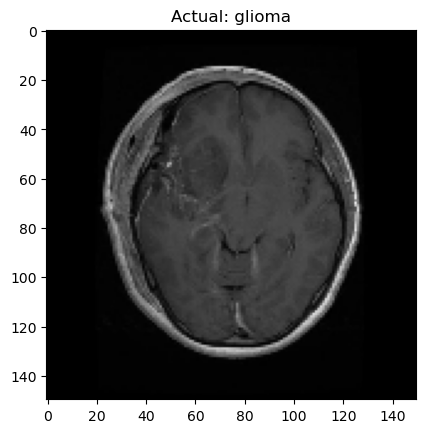

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Predicted Label -  pituitary


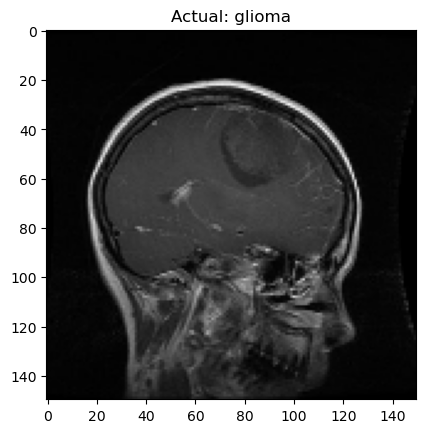

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predicted Label -  glioma


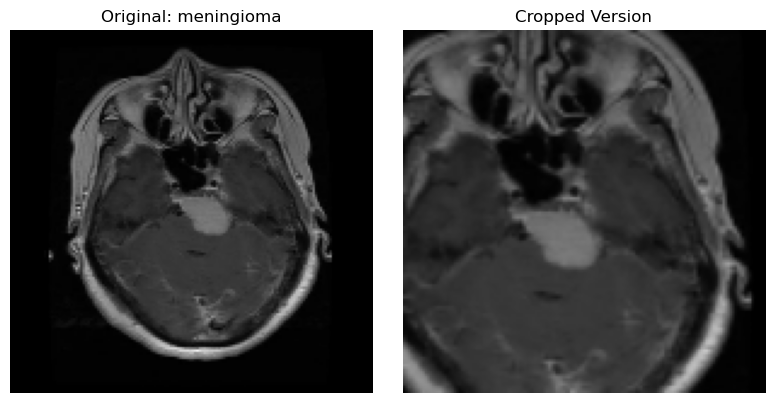

In [45]:
def get_name(n):
    return labels[n]

n = np.random.randint(0, len(X_test))
img = X_test[n]
plt.imshow(img)
plt.title(f"Actual: {get_name(y_test_original[n])}")
plt.show()


predicted_value = model.predict(X_test[n].reshape(1, image_size, image_size, 3))
predicted_class = np.argmax(predicted_value)
print('Predicted Label - ', get_name(predicted_class))


n = np.random.randint(0, len(X_test))
img = X_test[n]
plt.imshow(img)
plt.title(f"Actual: {get_name(y_test_original[n])}")
plt.show()


predicted_value = model.predict(X_test[n].reshape(1, image_size, image_size, 3))
predicted_class = np.argmax(predicted_value)
print('Predicted Label - ', get_name(predicted_class))
#  Function to crop a random region
def random_crop(img, crop_size=100):
    height, width = img.shape[:2]
    start_x = np.random.randint(0, width - crop_size)
    start_y = np.random.randint(0, height - crop_size)
    return img[start_y:start_y + crop_size, start_x:start_x + crop_size]

# Randomly pick an image
n = np.random.randint(0, len(X_test))
img = X_test[n]
label = get_name(y_test_original[n])

# Apply crop
cropped_img = random_crop(img, crop_size=100)
cropped_img = cv2.resize(cropped_img, (150, 150))  # Resize to match original size

# Plot both
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f"Original: {label}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cropped_img)
plt.title("Cropped Version")
plt.axis('off')

plt.tight_layout()
plt.show()

